# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
import copy
from omegaconf import OmegaConf, open_dict
import numpy as np
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=april_analytic'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.data.partition="balanced"
cfg.case.user.user_idx = 0
cfg.case.user.num_data_points = 64
cfg.case.model='vit_small_april'
cfg.case.server.pretrained=True
cfg.case.user.provide_labels = True

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture vit_small_april loaded with 22,049,896 parameters and 0 buffers.
Overall this is a data ratio of       2:1 for target shape [64, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small_april
        model state: default
        

    Secrets: {}
    
Attacker (of type AprilAttacker).


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep) with settings:
    Number of data points: 64

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: vit_small_april
        model state: default
        

    Secrets: {}
    
Attacker (of type AprilAttacker).


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()

cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}
server.reconfigure_model('cls_attack', extra_info=extra_info)

In [7]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

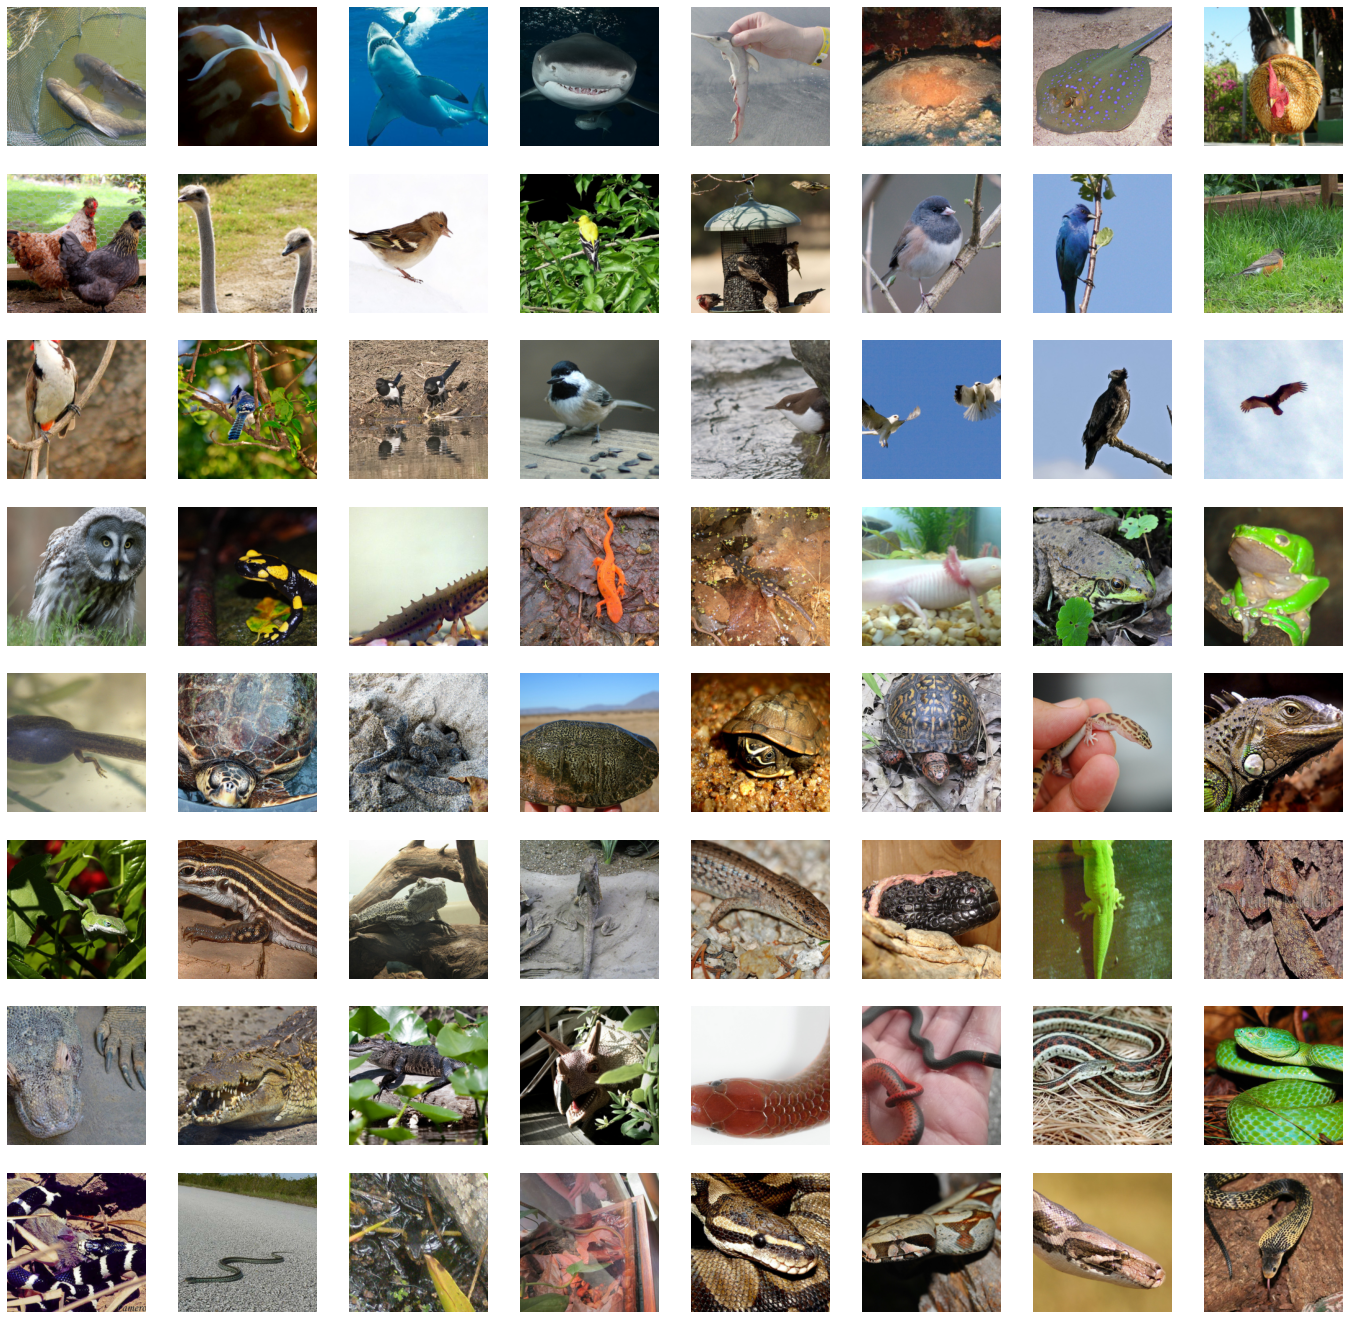

In [8]:
user.plot(true_user_data)

### Reconstruct user data:

In [9]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = 1
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many)]

tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many)]

Attention Inversion:  ||A||=0.03818831676850377, ||b||=1.0121621990320024
Embedding Inversion:  ||A||=26.286054163313743, ||b||=213.49871975040438


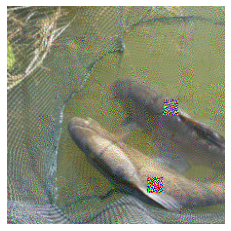

In [11]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)
user.plot(reconstructed_user_data)

In [12]:
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0089 | PSNR: 20.51 | FMSE: 3.4816e-01 | LPIPS: 0.22|
 R-PSNR: 23.36 | IIP-pixel: 100.00% | SSIM: 0.7261 | max R-PSNR: 23.36 | max SSIM: 0.7261 | Label Acc: 100.00%
